In [1]:
import numpy as np
import pandas as pd 
import uniprot_util
import nosc_util
import seaborn as sns

from Bio.SeqUtils import molecular_weight
from Bio import SeqIO
from collections import Counter
from matplotlib import pyplot as plt
from os import path
from tqdm import tqdm

# Preprocessing reference proteomes (coding sequences)
Reference proteomes from UniProt give the amino acid coding sequences of protein coding genes in many genomes. Here I am parsing the XML reference proteomes used in various mass spec proteomics studies (E. coli, yeast, cyanobacteria, etc.) to gather sequence information (sequence, carbon count, nominal oxidation state of carbon) and metadata (IDs, functional tags). 

See uniprot_util.py for parsing code. 

Note that we are parsing the E. coli b numbers (gene identifiers) from the reference proteome XML since the E. coli data from the Bellevue & Chure paper uses these identifiers. 

In [2]:
# List of the reference proteomes to parse
ref_prot_metadata = pd.read_csv('../data/genomes/reference_proteomes.csv', index_col=0)
ref_prot_metadata.head()

,species,strain,refseq_id,ref_proteome_fname,extract_b_num,CDS_NOSC_csv_fname,KEGG_pathways_fname,KEGG_pathway_mapping_fname
key,,,,,,,,
coli,E. coli,MG1655 K12,UP000000625,data/genomes/Coli/MG1655/UP000000625_83333.xml.gz,True,data/genomes/Coli/MG1655/MG1655_ref_prot_NOSC.csv,data/genomes/Coli/KEGG_pathways.tsv,data/genomes/Coli/KEGG_pathway_mapping.tsv
yeast,S. cerevisiae,S288c,UP000002311,data/genomes/Scer/S288c/UP000002311_559292.xml.gz,False,data/genomes/Scer/S288c/S288c_ref_prot_NOSC.csv,data/genomes/Scer/KEGG_pathways.tsv,data/genomes/Scer/KEGG_pathway_mapping.tsv
PCC6803,Synechocystis sp.,PCC6803,UP000001425,data/genomes/Synechocystis/PCC6803/UP000001425...,False,data/genomes/Synechocystis/PCC6803/PCC6803_ref...,data/genomes/Synechocystis/KEGG_pathways.tsv,data/genomes/Synechocystis/KEGG_pathway_mappin...


In [3]:
# Load amino acid NOSC table -- used to calculate protein NOSC values
aa_nosc_df = pd.read_csv('../data/aa_nosc.csv').set_index('letter_code')
aa_nosc_df.head()

,full_name,short_name,NC,Formula,NOSC,MW,polar_requirement,hydropathy,molecular_volume,isoelectric_point
letter_code,,,,,,,,,,
A,Alanine,ala,3,C3H7NO2,0.00,89.0935,7.0,1.8,31.0,6.00
R,Arginine,arg,6,C6H15N4O2+,0.33,174.2017,9.1,-4.5,124.0,10.76
N,Asparagine,asn,4,C4H8N2O3,1.00,132.1184,10.0,-3.5,56.0,5.41
D,Aspartate,asp,4,C4H6NO4−,1.00,133.1032,13.0,-3.5,54.0,2.77
C,Cysteine,cys,3,C3H7NO2S,0.67,121.1590,4.8,2.5,55.0,5.07


In [4]:
cds_dfs = {}
isoform_fname = '../data/genomes/uniprot_sprot_varsplic.fasta'

for idx, row in tqdm(ref_prot_metadata.iterrows()):
    print(idx)
    fpath = path.join('../', row.ref_proteome_fname)
    # Only gets the dominant isoform sequences
    my_df = uniprot_util.uniprot_xml2df(fpath, extract_b_number=row.extract_b_num)
    
    # Adds sequences for the secondary isoforms
    my_df = uniprot_util.add_isoforms2df(my_df, isoform_fname)
    
    # Load KEGG mappings for genes
    kegg_mapping_fname = path.join('../', row.KEGG_pathway_mapping_fname) 
    kegg_pathways_fname = path.join('../', row.KEGG_pathways_fname)
    uniprot_util.add_KEGGpathways2df(my_df, kegg_mapping_fname, kegg_pathways_fname)
    
    # Add NOSC information
    new_cols = my_df.aa_seq.apply(nosc_util.calc_protein_nosc, args=(aa_nosc_df,)).apply(pd.Series)
    new_cols.columns = 'Ce_total,NC'.split(',')
    my_df = my_df.merge(new_cols, left_index=True, right_index=True)
    my_df['NOSC'] = my_df.Ce_total / my_df.NC
    my_df['eC_ratio'] = 4 - my_df.NOSC
    my_df['organism'] = idx
    # Do we need molecular weight? 
    
    # Make sure we have unique b-numbers for E. coli
    if row.extract_b_num:
        count_bs = pd.Series(Counter(my_df.b_number.values))
        mask = count_bs > 1
        if mask.any():
            print('Found duplicate b-numbers:')
            print(count_bs[mask])
            print('Dropping these')
            
            # Dropping the duplicates because there is just one duplicate b number 
            # and it is found in none of the E. coli expression datasets anyway.
            todrop = my_df.b_number.isin(count_bs[mask].index.values)
            my_df = my_df.drop(my_df.loc[todrop].index, axis=0)
            
    # Store in memory for later cells if needed
    cds_dfs[idx] = my_df
    
    # Save as CSV
    out_fname = path.join('../', row.CDS_NOSC_csv_fname)
    my_df.to_csv(out_fname, index=False)

0it [00:00, ?it/s]

coli


1it [00:12, 12.60s/it]

Found duplicate b-numbers:
b4581    2
dtype: int64
Dropping these
yeast


2it [00:26, 13.09s/it]

PCC6803


3it [00:32, 11.00s/it]


In [5]:
tmp = cds_dfs['coli']
tmp[tmp.KEGG_path_IDs != '']

,aa_seq,num_aas,mw_daltons,transmembrane_aas,fraction_transmembrane,primary_accession,accessions,gene_name,description,locus_tags,...,KEGG_IDs,isoform_accessions,b_number,KEGG_path_IDs,KEGG_pathways,Ce_total,NC,NOSC,eC_ratio,organism
2,MPELPEVETSRRGIEPHLVGATILHAVVRNGRLRWPVSEEIYRLSD...,269,30290.0,0,0.000000,P05523,"P05523,Q2M7U9",mutM,Formamidopyrimidine-DNA glycosylase,"mutM,fpg,b3635,JW3610",...,"ecj:JW3610,eco:b3635",,b3635,path:eco03410,Base excision repair - Escherichia coli K-12 M...,-231.79,1358.0,-0.170685,4.170685,coli
3,MSIVMQLQDVAESTRLGPLSGEVRAGEILHLVGPNGAGKSTLLARM...,249,27081.0,0,0.000000,P06611,P06611,btuD,Vitamin B12 import ATP-binding protein BtuD,"btuD,b1709,JW1699",...,"ecj:JW1699,eco:b1709",,b1709,path:eco02010,ABC transporters - Escherichia coli K-12 MG1655,-157.82,1189.0,-0.132733,4.132733,coli
4,MSENKLNVIDLHKRYGEHEVLKGVSLQANAGDVISIIGSSGSGKST...,257,28653.0,0,0.000000,P07109,"P07109,P77299",hisP,Histidine transport ATP-binding protein HisP,"hisP,b2306,JW2303",...,"ecj:JW2303,eco:b2306",,b2306,path:eco02010,ABC transporters - Escherichia coli K-12 MG1655,-201.82,1266.0,-0.159415,4.159415,coli
5,MLRVYHSNRLDVLEALMEFIVERERLDDPFEPEMILVQSTGMAQWL...,1122,128848.0,0,0.000000,P07648,"P07648,Q2MA15,Q9RNX9",recC,RecBCD enzyme subunit RecC,"recC,b2822,JW2790",...,"ecj:JW2790,eco:b2822",,b2822,path:eco03440,Homologous recombination - Escherichia coli K-...,-765.59,5786.0,-0.132318,4.132318,coli
7,MKTLFSRLITVIACFFIFSAAWFCLWSISLHLVERPDMAVLLFPFG...,500,56306.0,160,0.320000,P09835,"P09835,P76729,Q2M7Y1",uhpB,Signal transduction histidine-protein kinase/p...,"uhpB,b3668,JW3643",...,"ecj:JW3643,eco:b3668",,b3668,path:eco02020,Two-component system - Escherichia coli K-12 M...,-563.09,2568.0,-0.219272,4.219272,coli
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,MKRLIEATQFSMAHQDVRYYLNGMLFETEGEELRTVATDGHRLAVC...,232,40587.0,0,0.000000,P0A988-2,"P0A988,P00583,Q2M813",dnaN,Beta sliding clamp,"dnaN,b3701,JW3678",...,"ecj:JW3678,eco:b3701","P0A988-1,P0A988-2",b3701-P0A988-2,"path:eco03030,path:eco03430,path:eco03440",DNA replication - Escherichia coli K-12 MG1655...,-143.75,1136.0,-0.126540,4.126540,coli
4406,MSYQVLARKWRPQTFADVVGQEHVLTALANGLSLGRIHHAYLFSGT...,431,71138.0,0,0.000000,P06710-2,"P06710,A0A385XJC4,Q2MBV7,Q47721",dnaX,DNA polymerase III subunit tau,"dnaX,dnaZ,dnaZX,b0470,JW0459",...,"ecj:JW0459,eco:b0470","P06710-1,P06710-2",b0470-P06710-2,"path:eco03030,path:eco03430,path:eco03440",DNA replication - Escherichia coli K-12 MG1655...,-325.85,2095.0,-0.155537,4.155537,coli
4410,MEKPRVLVLTGAGISAESGIRTFRAADGLWEEHRVEDVATPEGFDR...,242,31464.0,0,0.000000,P75960-2,P75960,cobB,NAD-dependent protein deacylase,"cobB,ycfY,b1120,JW1106",...,"ecj:JW1106,eco:b1120","P75960-1,P75960-2",b1120-P75960-2,"path:eco00760,path:eco01100",Nicotinate and nicotinamide metabolism - Esche...,-133.51,1189.0,-0.112288,4.112288,coli
4411,MPRKGKGKGKGRKPRGKRGWLWLLLKLAIVFAVLIAIYGVYLDQKI...,799,94293.0,23,0.027251,P02919-2,"P02919,P75664",mrcB,Penicillin-binding protein 1B,"mrcB,pbpF,ponB,b0149,JW0145",...,"ecj:JW0145,eco:b0149","P02919-1,P02919-2",b0149-P02919-2,"path:eco00550,path:eco01100",Peptidoglycan biosynthesis - Escherichia coli ...,-559.41,3952.0,-0.141551,4.141551,coli


In [6]:
# Load COG IDs and functional categories
cog_ids = pd.read_csv('../data/COG-20.def.tab.txt', sep='\t', encoding='cp1252', header=None)
cog_ids.columns = 'COG_ID,categories,name,gene,pathway,PubMed_IDs,PDB_ID'.split(',')
cog_ids = cog_ids.set_index('COG_ID')

cog_func = pd.read_csv('../data/COG-fun-20.tab.txt', sep='\t', header=None)
cog_func.columns = 'category,color,description'.split(',')
cog_func = cog_func.set_index('category')

cog_func.to_csv('../data/COG-fun-20.csv', index=True)
cog_ids.to_csv('../data/COG-20.def.csv', index=True)

In [7]:
# Load the go-terms -- this is a CSV made from the OBO file by Chure et al. 
go_terms = pd.read_csv('../data/go_terms.csv', index_col=0)

go_terms_of_interest = 'GO:0003735,GO:0017101,GO:0008652,GO:0042759'.split(',')
go_labels = 'ribosomal_protein,aminoacyl_tRNA_synthetase,amino_acid_biosynthesis,fatty_acid_biosynthesis'.split(',')
goti_dict = dict(zip(go_terms_of_interest, go_labels))
go_terms.loc[go_terms_of_interest]

,name,namespace,obsolete
id,,,
GO:0003735,structural constituent of ribosome,molecular_function,0.0
GO:0017101,aminoacyl-tRNA synthetase multienzyme complex,cellular_component,0.0
GO:0008652,cellular amino acid biosynthetic process,biological_process,0.0
GO:0042759,long-chain fatty acid biosynthetic process,biological_process,0.0


In [8]:
cols = 'organism,primary_accession,gene_name,description,GO_terms,COG_IDs,KEGG_IDs,KEGG_pathways,KEGG_path_IDs,fraction_transmembrane,num_aas,mw_daltons,NC,NOSC,Ce_total,eC_ratio'.split(',')
# needs a new index so as not to repeat
long_nosc_df = pd.concat([df.reset_index()[cols] for key, df in cds_dfs.items()]).reset_index().drop('index',axis=1)
# Need to do string ops below - replace NaN with empty string
long_nosc_df.GO_terms = long_nosc_df.GO_terms.replace({np.NaN: ''})

# Add columns for GO terms
labels_dict = dict((l, []) for l in go_labels)
for idx, row in long_nosc_df.iterrows():
    my_go_terms = row.GO_terms.split(',')
    for gt, gt_label in goti_dict.items():
        val = gt in my_go_terms
        labels_dict[gt_label].append(val)
for l, col in labels_dict.items():
    long_nosc_df[l] = col
    
# Add columns for COG categories.
# Using the first listed COG ID to retrieve categorial information.
cog_class_dict = dict(primary_COG_category=[], secondary_COG_category=[])
for idx, row in long_nosc_df.iterrows():
    COGs = row.COG_IDs.split(',')
    prim, sec = '', ''
    for c in COGs:
        if c in cog_ids.index:
            cats = cog_ids.loc[c].categories
            prim = cats[0]
            if len(cats) > 1:
                sec = cats[1]
            break
    cog_class_dict['primary_COG_category'].append(prim)
    cog_class_dict['secondary_COG_category'].append(sec)
for l, col in cog_class_dict.items():
    long_nosc_df[l] = col

long_nosc_df.infer_objects()
long_nosc_df.to_csv('../data/genomes/all_ref_prot_NOSC.csv', index=False)
long_nosc_df.head()

,organism,primary_accession,gene_name,description,GO_terms,COG_IDs,KEGG_IDs,KEGG_pathways,KEGG_path_IDs,fraction_transmembrane,...,NC,NOSC,Ce_total,eC_ratio,ribosomal_protein,aminoacyl_tRNA_synthetase,amino_acid_biosynthesis,fatty_acid_biosynthesis,primary_COG_category,secondary_COG_category
0,coli,A5A605,ykfM,Uncharacterized protein YkfM,"GO:0016020,GO:0006974,GO:0046677",ENOG5031M8I,eco:b4586,,,0.377358,...,862.0,-0.349478,-301.25,4.349478,False,False,False,False,,
1,coli,P02929,tonB,Protein TonB,"GO:0030313,GO:0009279,GO:0030288,GO:0005886,GO...",COG0810,"ecj:JW5195,eco:b1252",,,0.129707,...,1173.0,-0.208150,-244.16,4.208150,False,False,False,False,M,
2,coli,P05523,mutM,Formamidopyrimidine-DNA glycosylase,"GO:0034039,GO:0140078,GO:0003684,GO:0019104,GO...",COG0266,"ecj:JW3610,eco:b3635",Base excision repair - Escherichia coli K-12 M...,path:eco03410,0.000000,...,1358.0,-0.170685,-231.79,4.170685,False,False,False,False,L,
3,coli,P06611,btuD,Vitamin B12 import ATP-binding protein BtuD,"GO:0043190,GO:1990191,GO:0019898,GO:0015420,GO...",COG4138,"ecj:JW1699,eco:b1709",ABC transporters - Escherichia coli K-12 MG1655,path:eco02010,0.000000,...,1189.0,-0.132733,-157.82,4.132733,False,False,False,False,H,
4,coli,P07109,hisP,Histidine transport ATP-binding protein HisP,"GO:0055052,GO:0015424,GO:0005524,GO:0005291,GO...",COG4598,"ecj:JW2303,eco:b2306",ABC transporters - Escherichia coli K-12 MG1655,path:eco02010,0.000000,...,1266.0,-0.159415,-201.82,4.159415,False,False,False,False,E,


In [9]:
mask = long_nosc_df.secondary_COG_category != ''
long_nosc_df[mask]

,organism,primary_accession,gene_name,description,GO_terms,COG_IDs,KEGG_IDs,KEGG_pathways,KEGG_path_IDs,fraction_transmembrane,...,NC,NOSC,Ce_total,eC_ratio,ribosomal_protein,aminoacyl_tRNA_synthetase,amino_acid_biosynthesis,fatty_acid_biosynthesis,primary_COG_category,secondary_COG_category
12,coli,P0A823,sfsA,Sugar fermentation stimulation protein A,"GO:0003677,GO:0009891",COG1489,"ecj:JW0142,eco:b0146",,,0.000000,...,1160.0,-0.123828,-143.64,4.123828,False,False,False,False,G,T
19,coli,P0A9N0,ptsO,Phosphocarrier protein NPr,"GO:0005737,GO:0016772,GO:0009401,GO:0006468,GO...",COG1925,"ecj:JW3173,eco:b3206",Phosphotransferase system (PTS) - Escherichia ...,path:eco02060,0.000000,...,426.0,-0.135986,-57.93,4.135986,False,False,False,False,T,G
28,coli,P0AEF8,dppB,Dipeptide transport system permease protein DppB,"GO:0055052,GO:0005886,GO:0071916,GO:0042938,GO...",COG0601,"ecj:JW3512,eco:b3543",ABC transporters - Escherichia coli K-12 MG1655,path:eco02010,0.412979,...,1729.0,-0.292302,-505.39,4.292302,False,False,False,False,E,P
31,coli,P0AF32,narV,Respiratory nitrate reductase 2 gamma chain,"GO:0009325,GO:0005886,GO:0009055,GO:0020037,GO...",COG2181,"ecj:JW1460,eco:b1465",Nitrogen metabolism - Escherichia coli K-12 MG...,"path:eco00910,path:eco01100,path:eco01120,path...",0.504425,...,1222.0,-0.259394,-316.98,4.259394,False,False,False,False,C,P
60,coli,P33232,lldD,L-lactate dehydrogenase,"GO:0005886,GO:0010181,GO:0004459,GO:0009060,GO...",COG1304,"ecj:JW3580,eco:b3605",Pyruvate metabolism - Escherichia coli K-12 MG...,"path:eco00620,path:eco01100",0.000000,...,1900.0,-0.150332,-285.63,4.150332,False,False,False,False,C,I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13967,PCC6803,Q55146,sll0064,None,GO:0030288,COG0834,syn:sll0064,,,0.000000,...,1361.0,-0.201007,-273.57,4.201007,False,False,False,False,E,T
13968,PCC6803,Q55178,slr0487,None,,COG3829,syn:slr0487,,,0.000000,...,824.0,-0.143204,-118.00,4.143204,False,False,False,False,K,T
13978,PCC6803,Q55689,rfbA,None,"GO:0016779,GO:0009058","COG1208,COG1209",syn:sll0207,Streptomycin biosynthesis - Synechocystis sp. ...,"path:syn00521,path:syn00523,path:syn00525,path...",0.000000,...,1930.0,-0.204907,-395.47,4.204907,False,False,False,False,J,M
13981,PCC6803,Q55802,slr0081,None,"GO:0005829,GO:0032993,GO:0001216,GO:0000156,GO...",COG0745,syn:slr0081,Two-component system - Synechocystis sp. PCC 6803,path:syn02020,0.000000,...,1344.0,-0.175335,-235.65,4.175335,False,False,False,False,T,K


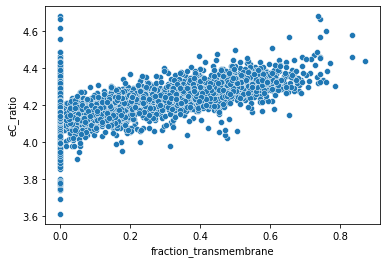

In [10]:
# Transmembrane fraction against NOSC. fraction_transmembrane < 0 indicates a parse error
# There is currently only one such example, a yeast protein
mask = long_nosc_df.fraction_transmembrane >= 0 
sns.scatterplot(data=long_nosc_df[mask], x='fraction_transmembrane', y='eC_ratio')
plt.savefig('../output/tm_proteins_redox.png', facecolor='w', dpi=300)